In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect
import string
import data_collector
import parser
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
import pickle
import math
import numpy as np
import heapq
import re
import functions

In [21]:
import pandas as pd

# 1. Data Collection
Maybe it is important to write some notes about this part. There are two main possible approaches to retrieve correctly the data.

The classical one is to just retrieve the books using `requests`. This obviously works, and as long as the syntax is correct, there is no problem with that. Unfortunately, downloading one book at a time takes a really long time, going from 10 to 20 hours. This is a lot, even if we split the work between teammates! A simple but effective trick could be to run the same program different times, simultaneously. In fact, this doesn't represent a heavy task (at least for our pc!). To exploit this little trick, we have to make sure that the program is actually starting from different points, and that there is no overlapping between the different runs. Moreover, we don't want to download books that we already downloaded, even if an overlapping takes place. Actually, this is something that we want to make sure for each and every approach we can think of!

If we actually try to exploit this trick, we can see that our computer can run several (more than 10, for instance) runs at once. This fact should certainly encourage us to consider a different approach: if our computer can actually run different instances at the same time without making a sound, maybe there is a better (and more natural) way to approach this problem! And in fact there is! This kind of work is well described by one single word: multiprocessing! Ok, maybe more than one: multiprocessing, multithreading, asynchronous programming... etc. These are all different words that describe similar phenomenons, that we can summarise with: make our pc do different things at once.

We decided to use asynchronous programming, using the `asyncio` library. It is not actually that easy to understand what this does, at least without first becoming somewhat proficient, but the main concept is that we let our system download multiple chunks of books at the same time. This really makes the download go faster! For instance, we were able to download the complete set of books htmls (30000) in just 20 minutes. Cool, isn't it? We're not going to explain every single passage of the program here, but this is the idea:

First, we downloaded the html pages for the best book pages (e.g., https://www.goodreads.com/list/show/1.Best_Books_Ever?page=1). From these, we extracted all the links (and we actually did this in a pretty standard way), then we proceedeed with the download of the 30000 html pages, downloading simultaneously batches of 100 books. Once this was done, we used `rm_fails` to remove books that were either corrupted or empty (books with a size too small).

If one wants to learn a little bit more about asynchronous programming, there is an interesting link explaining some of the basics (and not so basic). The blogpost name, [I’m too stupid for AsyncIO](https://whatisjasongoldstein.com/writing/im-too-stupid-for-asyncio/), let's us understand that we're all on the same boat. It's an hard programming paradigm.

## Get the list of the books
We already have the list of books in the pc, so we won't do it again. When submitted, all the parameters should be `True`.

Set to `True` both dirs, bests and links parameters to create the correct directories and download the txt containing all the html links.

In [2]:
data_collector.download_books(dirs=True, bests=True, links=True)

## 1.1 Crawl books
We already have all the htmls in the pc, so we won't do it again. When submitted, all the parameters should be `True`.

Set to `True` both the books and fails parameters to download all the html pages and remove the ones with broken pages.

In [3]:
data_collector.download_books(books=True, fails=True)

## 1.2 Parse downloaded pages
Set to `True` the create parameter to parse the downloaded html pages and create the tsv file (takes a lot parse all the pages).

In [4]:
parser.create_tsv(create=False)

In [5]:
df = pd.read_csv('./data/parsed_books.tsv', sep='\t')

In [6]:
df.shape

(29959, 12)

In [7]:
df.head()

,bookTitle,bookSeries,bookAuthors,ratingValue,ratingCount,reviewCount,Plot,numberOfPages,PublishingDate,Characters,Setting,Url
0,The Hunger Games,The Hunger Games #1,Suzanne Collins,4.33,6408798.0,172554.0,"Could you survive on your own in the wild, wit...",374.0,September 14th 2008,Katniss Everdeen Peeta Mellark Cato (Hunger Ga...,"District 12, Panem Capitol, Panem Panem",https://www.goodreads.com/book/show/2767052-th...
1,Harry Potter and the Order of the Phoenix,Harry Potter #5,J.K. Rowling,4.50,2525157.0,42734.0,There is a door at the end of a silent corrido...,870.0,September 2004,Sirius Black Draco Malfoy Ron Weasley Petunia ...,Hogwarts School of Witchcraft and Wizardry Lon...,https://www.goodreads.com/book/show/2.Harry_Po...
2,To Kill a Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,4527405.0,91802.0,The unforgettable novel of a childhood in a sl...,324.0,May 23rd 2006,Scout Finch Atticus Finch Jem Finch Arthur Rad...,"Maycomb, Alabama",https://www.goodreads.com/book/show/2657.To_Ki...
3,Pride and Prejudice,NaN,Jane Austen,4.26,3017830.0,67811.0,Alternate cover edition of ISBN 9780679783268S...,279.0,October 10th 2000,Mr. Bennet Mrs. Bennet Jane Bennet Elizabeth B...,"United Kingdom Derbyshire, England England Her...",https://www.goodreads.com/book/show/1885.Pride...
4,Twilight,The Twilight Saga #1,Stephenie Meyer,3.60,4989910.0,104912.0,About three things I was absolutely positive.F...,501.0,September 6th 2006,Edward Cullen Jacob Black Laurent Renee Bella ...,"Forks, Washington Phoenix, Arizona Washington ...",https://www.goodreads.com/book/show/41865.Twil...


## 1.3 Dataset cleaning [preliminary steps]
Before actually jumping into the work itself, we want our dataframe to be clean, meaning that there are some preliminary steps we need to perform on it. First of all, missing data is something we should pay attention to. Lots of rows are going to have missing data somewhere, and dealing with missing data it's not that nice. Notice that this will include different strategies for each of the column we will be considering (more details below). Then there is the problem with punctuation, stopwords, stems and so on so forth, so basic text data preprocessing. Let's make a brief recap:

1. **Missing data**
    - `bookTitle`: if a book is missing the title, then we can safely just remove the instance. In fact, books that are missing the title are actually missing all the informations, meaning that there is a problem with the GoodReads specific link. Also, even if a book was missing just the title, we wouldn't have a way to refer to it, thus it wouldn't be really useful considering we're building a search engine.
    - `bookSeries`, `Authors`, `Plot`, `PublishingDate`, `Characters`, `Setting`: if a book is missing one of the above mentioned columns, we can still include the book in the data, since the search engine could for example work with just the title. Obviously, we cannot just leave the values missing, since it would be really hard to perform any operation on that. These are all text columns, therefore the best way to address the missing values prolem is to replace NaNs with empty strings.

2. **Text data preprocessing**
    - Punctuation removal: this is the first step we want to perform, since it is going to make the next steps much easier (e.g., language detection will be easier if there aren't plots composed just by punctuation symbols).
    - Language detection: before doing anything else, we want to remove the books that present the books for which the plot isn't in english.
    - Stopwords removal (of the `Plot` column only)
    - Stemming (of the `Plot` column only)
    - Lowercase

### Missing values

#### Title
There are 774 books that are completely empty, and these corresponds to the ones that are missing the `bookTitle` column. If you give a look at the url, you can see that these are not given by our python script to download and parse the books, but actually from the fact that the link is broken. Also, you can see that all the books that are missing the `bookTitle` are also missing all the remaining data.

This means that we can safely just remove all the rows that are missing the `bookTitle` column.

In [8]:
functions.book_title_summary(df)

There are 774 instances that are missing the `bookTitle` column.



,bookTitle,bookSeries,bookAuthors,ratingValue,ratingCount,reviewCount,Plot,numberOfPages,PublishingDate,Characters,Setting,Url
311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/40937505\r\n
370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/30528535\r\n
379,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/30528544\r\n
789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/40941582\r\n
1141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://www.goodreads.com/book/show/5295735\r\n


In [9]:
# Remove empty books
df = df[(df['bookTitle'].notna())]

#### Text data
To handle missing data in the preprocessing, we'll need to convert NaNs to empty strings, for text data.

In [10]:
str_columns = ['bookSeries', 'bookAuthors', 'Plot', 'PublishingDate', 'Characters', 'Setting']

for col in str_columns:
    df[col] = df[col].fillna('')

### Text data preprocessing

#### Punctuation removal
Our first approach was to use the nltk package, like for everything else we did in the text preprocessing part, but we noticed that it has a little bug when dealing with strings that have a minus character `-`. In fact, it tends to just ignore it. For this reason, we decided to use regex and create our function from scratch.

In [11]:
for col in str_columns:
    if col != 'bookSeries':
        df[col] = df[col].apply(functions.remove_punctuation)

#### Language detection
There are four possibilities `Plot` column of a given book:
1. It is written in english
2. It is written in another language
3. It is empty
4. It contains symbols, numbers, and so on

We want to keep only the ones written in english, so we are just going to discard the others.

In [12]:
df['plot_lang'] = df['Plot'].apply(functions.language_det)

df = df[df['plot_lang'] == 'en'].drop(columns=['plot_lang'])

In [13]:
df.shape

(26120, 12)

#### Stopwords removal
We are not going to perform stopwords removal on all the columns, since we could remove important things (e.g., we don't want to remove anything from the names of the characters). The only column on which stopwords removal is necessary is `Plot`.

In [14]:
df['Plot'] = df['Plot'].apply(functions.remove_stopwords)

#### Stemming
As for the stopwords removal, the only column on which stemming is necessary is `Plot`. Notice that we're using the stemming function twice, since there are words that are stemmed in really similar roots (we noticed that there are words that are either stemmed to *games* or *game*). This shouldn't be the case! If we apply stemming again, we should solve this issue.

In [15]:
df['Plot'] = df['Plot'].apply(functions.stemming)
df['Plot'] = df['Plot'].apply(functions.stemming)

#### Lowercase
On the other hand, we want all the string columns to be lowercase, so that our search engine won't have problems with upper/lower case differences.

In [16]:
for col in str_columns:
    df[col] = df[col].apply(lambda w: w.lower())

### Save data

In [17]:
df = df.reset_index(drop=True).reset_index()

df.to_csv('./data/clean_data.csv', index=False)

# 2. Search Engine

## 2.1 Conjunctive query
The first search engine we are going to build is a really naive one. It's just going to retrieve documents through an AND search, without the help of a scoring function to better show the results in an appropriate way. This obviously means that when the user is going to enter a query, he's not going to obtain interesting results, he's just going to obtain the full range of results he searched for, without any logic order.

If we actually try to use this search engine to search for "survival games", we can see that it seems to work in a pretty good way. It shows us the results we would expect us to find! Unfortunately, this is just given by the fact that the books were **previously** sorted so that the best books (in the GoodReads page) were first. In a more realistic scenario, we're just going to have our database,and we wouldn't have any specific a priori pattern whatsoever. Meaning that a more realistic result page would look something like our results, but shuffled. In the following cells, we are going to show both the results given by the the search engine as it is (that we again specify is somehow biased by the fact that GoodReads already sorted the results), and how they would look like in a more realistic scenario.

### 2.1.1 Create your index!

In [18]:
# Read data
df = pd.read_csv('./data/clean_data.csv')

In [19]:
# term_indexes = functions.term_index(df['Plot'])
# inv_indexes = functions.inverted_index(df['Plot'], term_indexes)

# functions.save_obj(term_indexes, 'vocabulary')
# functions.save_obj(inv_indexes, 'inverted_index')

term_indexes = functions.load_obj('vocabulary')
inv_indexes = functions.load_obj('inverted_index')

### 2.1.2 Execute the query

In [20]:
simple_SE = functions.SimpleSearchEngine(df, term_indexes, inv_indexes)

simple_SE.execute_query('survival games')

,bookTitle,Plot,Url
0,The Hunger Games,could surviv wild everi one make sure live see...,https://www.goodreads.com/book/show/2767052-th...
221,Catching Fire,spark are ignit flame are spread and the capit...,https://www.goodreads.com/book/show/6148028-ca...
319,Mockingjay,the final book ground break hunger game trilog...,https://www.goodreads.com/book/show/7260188-mo...
337,Legend,what western unit state home republ nation per...,https://www.goodreads.com/book/show/9275658-le...
652,The Magus,thi dare literari thriller rich erot suspen on...,https://www.goodreads.com/book/show/16286.The_...
...,...,...,...
25061,The Manhattan Hunt Club,in manhattan hunt club john saul plumb depth m...,https://www.goodreads.com/book/show/6553.The_M...
25525,Love's Forbidden Flower,plea note thi new adult romanc novel involv tw...,https://www.goodreads.com/book/show/16189423-l...
25800,The Southpaw,the southpaw stori come age america way baseb ...,https://www.goodreads.com/book/show/413736.The...
25821,Devil's Own,after surviv slaveri aiden macalpin noth thoug...,https://www.goodreads.com/book/show/8705483-de...


### Observation
As we already pointed out, in the next cell there is what our search engine would extract in a real scenario, without any previous pattern in the database. As we can see, this doesn't really make any sense. Yeah, what we're expecting is probably here somewhere, but there are just too many results and they have no organization/scoring function, so that we are just stuck with a walltext of results from which we can extract nothing.

Notice that `sample(frac=1)` extracts all the rows of a given dataframe and just randomizes the order.

In [36]:
simple_SE.execute_query('survival games').sample(frac=1)

,bookTitle,Plot,Url
8368,The Stolen Throne,the thrill prequel dragon age origin hit role ...,https://www.goodreads.com/book/show/6227080-th...
22902,Secret Society,miasha s stun debut novel with a twist that wi...,https://www.goodreads.com/book/show/184999.Sec...
13852,The Trap,from author andrew fukuda come the trap explo ...,https://www.goodreads.com/book/show/17286729-t...
21172,Psion Beta,sammi 14 year old fugit accid discov power psi...,https://www.goodreads.com/book/show/10779996-p...
7285,The Maze Runner Series (The Maze Runner #1-4),the perfect gift fan the hunger game diverg bo...,https://www.goodreads.com/book/show/20360301-t...
...,...,...,...
14394,Day Zero,arcana mean secret arcana chronicl short stori...,https://www.goodreads.com/book/show/24419968-d...
3856,U-10,the u 10 surviv kit might surviv use activ unr...,https://www.goodreads.com/book/show/51106657-u...
25525,Love's Forbidden Flower,plea note thi new adult romanc novel involv tw...,https://www.goodreads.com/book/show/16189423-l...
18532,The Warden,alic led normal life she wake find trap sick g...,https://www.goodreads.com/book/show/33655366-t...


## 2.2 Conjunctive query & Ranking score
Our second attempt is made by taking into account some simple ranking score: the cosin similarity between the tfidf vector space of the query, and the one produced by the documents retrieved by a simple conjunctive query search. Moreover, now we are just going to show a small slice of the complete results dataframe. This is not reductive in any way! In fact, if we retrieve just a small amount of documents, the user can actually manually go result by result searching for what he was really asking. Not only that, but if we think about big search engines (Google, for instance) and how we use them, it's really uncommon to go after the first page of results. This happens because we humans are intrinsically lazy! And also, cause it's not really that easy to discern good results from bad ones, so we just expect the first ones to be good.

Anyway, cosin similarity isn't really the best solution, because we're lacking important information. In fact, what we would expect our book description to be, isn't actually what it always is. We have to remember that the `Plot` column of our database contains just small summaries of the books, not the entire book text. It would change the world to have the complete book texts in our hands.

N.B.: there are actually many works, completely unrelated to this one, that proves that the interity of the text of singular books can infer really interesting info; simple machine learning models can extract author, literary genre and so on so forth.

### 2.2.1 Inverted index

In [21]:
# tfidf_indexes = functions.tfidf_inv_indexes(df['Plot'], term_indexes, inv_indexes)

# functions.save_obj(tfidf_indexes, 'tfidf_index')

tfidf_indexes = functions.load_obj('tfidf_index')

### 2.2.2 Execute the query

In [22]:
scoring_function = functions.ByTfidf(tfidf_indexes)

tfidf_SE = functions.RankedSearchEngine(df, term_indexes, inv_indexes, tfidf_indexes, simple_SE, scoring_function)

tfidf_SE.execute_query('survival games')

,bookTitle,Plot,Url,Similarity
0,The Warden,alic led normal life she wake find trap sick g...,https://www.goodreads.com/book/show/33655366-t...,0.350577
1,Devil's Own,after surviv slaveri aiden macalpin noth thoug...,https://www.goodreads.com/book/show/8705483-de...,0.277339
2,The Quillan Games,let the game beginquillan territori verg destr...,https://www.goodreads.com/book/show/215540.The...,0.247548
3,The Hunger Games,could surviv wild everi one make sure live see...,https://www.goodreads.com/book/show/2767052-th...,0.225207
4,Truth,from new york time usa today bestsel author al...,https://www.goodreads.com/book/show/16070018-t...,0.174879
5,The Books of the South,march south ghastli battl tower charm black co...,https://www.goodreads.com/book/show/2365730.Th...,0.173736
6,Cage of Darkness,while travel fren allyssa odar hijack ruthless...,https://www.goodreads.com/book/show/33893388-c...,0.162624
7,Warcross,for million log everi day warcross game way li...,https://www.goodreads.com/book/show/41014903-w...,0.150787
8,Becoming Noah Baxter,part two two part seri jay lili complet way on...,https://www.goodreads.com/book/show/18926659-b...,0.146785
9,Mockingjay,the final book ground break hunger game trilog...,https://www.goodreads.com/book/show/7260188-mo...,0.146581


# 3. Define a new score!

For this particular task, we didn't feel like a search engine like this could benefit from multiple type of information in the query. Instead, we tought about creating a new scoring function by analizing ratings value, ratings count and book title. In fact, the vast majority of times the user is more inclined in doing particular task in a single query, instead of adding more fields to the query itself. This means that a user probably prefers to write the name of the book or just some words to describe it, and then he just waits for the books that he wants to appear. In order to do that, we need to keep in mind that more often than not a user is interested in the most famous books, so the ones that have a really high number of ratings.

Also, it is probably optimal to give some value to the fact that a book is well written, and therefore that it has good ratings. Unfortunately, in our opinion the rating value isn't really telling, since it is often the case that a user either gives a max score to an item, or he gives the worst. Also, we need to keep in mind that we're considering a list of so-called "best books", so they probably all have good ratings (or at least the vast majority of them). We can analyze this trend, by looking at the `ratingValue` column. As we can see from the below cell, the vast majority of books have a value between 4 and 5, just one slot. This means that the weight we are going to give to this factor is going to be really low.

In [23]:
functions.rating_value_summary(df)

There are 11078 books with rating value between 0 and 4
There are 14557 books with rating value greater than 4


Then it comes the book title: we need to give value to the title column, since we want to keep in mind that if a user search for a word (or multiple words) that appears in one book title, he's probably searching for that book. For this reason, we used an exact match search in the book title, meaning that for each word in the query, we give value to this kind of match if and only if the word appears in a book title. Obviously, if a book has a really long title, this value should decrease, because it becomes easier to match a word in that given title.

Finally, we still wanted to keep the tfidf cosin similiarity, since it is important to mantain some kind of check between the query and the plot, and this seemed like the best option.

## Putting all together
1) **TfIdf** ($\mathrm{tfidf}$): like before, we will use the cosin similiarity between the tfidf of the query and the books ones.

2) **Rating Value** ($\mathrm{R_V}$): we are going to extract a value between 0 and 1, which will be the rating value for a particular book over the max rating value.

3) **Rating Count** ($\mathrm{R_C}$): we are going to extract a value between 0 and 1, which will be the rating count for a particular book over the max rating count.

4) **Book Title Match** ($\mathrm{T_M}$): we are going to extract a value between 0 and 1, which will be the number of query words found in a given book title over the number of words in the book title.

Finally, we are going to use a weighted sum. The new ranking score for a query $q$ and a given book $b_i$ will look something like this:

$$\mathrm{Rnk}(q, b_i) = \frac{25 \cdot \mathrm{tfidf}(q, b_i) + 10 \cdot \mathrm{R_V}(q, b_i) + 35 \cdot \mathrm{R_C}(q, b_i) + 30 \cdot \mathrm{T_M}(q, b_i)}{25 + 10 + 35 + 30}$$

In [24]:
rank_calculator = functions.WeightedRanks([
    (25, functions.ByTfidf(tfidf_indexes)),
    (10, functions.ByRatingValue(df)),
    (35, functions.ByRatingCount(df)),
    (30, functions.ByTitleMatch())
])


rnkd_SE = functions.RankedSearchEngine(df, term_indexes, inv_indexes, tfidf_indexes, simple_SE, rank_calculator)

rnkd_SE.execute_query('survival games')

,bookTitle,Plot,Url,Similarity
0,The Hunger Games,could surviv wild everi one make sure live see...,https://www.goodreads.com/book/show/2767052-th...,0.558884
1,Wicked Games,abbi lewi never pictur surviv game show endur ...,https://www.goodreads.com/book/show/10719342-w...,0.263272
2,The Quillan Games,let the game beginquillan territori verg destr...,https://www.goodreads.com/book/show/215540.The...,0.246732
3,Mockingjay,the final book ground break hunger game trilog...,https://www.goodreads.com/book/show/7260188-mo...,0.233584
4,Catching Fire,spark are ignit flame are spread and the capit...,https://www.goodreads.com/book/show/6148028-ca...,0.222396
5,The Warden,alic led normal life she wake find trap sick g...,https://www.goodreads.com/book/show/33655366-t...,0.169846
6,Devil's Own,after surviv slaveri aiden macalpin noth thoug...,https://www.goodreads.com/book/show/8705483-de...,0.145947
7,Truth,from new york time usa today bestsel author al...,https://www.goodreads.com/book/show/16070018-t...,0.132435
8,The Books of the South,march south ghastli battl tower charm black co...,https://www.goodreads.com/book/show/2365730.Th...,0.129152
9,Cage of Darkness,while travel fren allyssa odar hijack ruthless...,https://www.goodreads.com/book/show/33893388-c...,0.126725


In [30]:
rank_calculator = functions.WeightedRanks([
    (25, functions.ByTfidf(tfidf_indexes)),
    (10, functions.ByRatingValue(df)),
    (35, functions.ByRatingCount(df)),
    (30, functions.ByTitleMatch())
])


rnkd_SE = functions.RankedSearchEngine(df, term_indexes, inv_indexes, tfidf_indexes, simple_SE, rank_calculator)

rnkd_SE.execute_query('pink')

,bookTitle,Plot,Url,Similarity
0,One Pink Line,can love lifetim forev chang one pink line din...,https://www.goodreads.com/book/show/13108849-o...,0.282071
1,Pink Slips,aldrich book deliv solidli structur detail fil...,https://www.goodreads.com/book/show/35183676-p...,0.250571
2,The Pink Dress,a dab perfum new pink dress sue transform hero...,https://www.goodreads.com/book/show/1780471.Th...,0.219255
3,The Secret History of the Pink Carnation,decid true romant hero thing past eloi kelli i...,https://www.goodreads.com/book/show/84351.The_...,0.193660
4,Princess in Pink,princess mia dream prom contend hotel worker s...,https://www.goodreads.com/book/show/93731.Prin...,0.189402
5,The Case of the Peculiar Pink Fan,when enola holm encount friend ladi cecili hid...,https://www.goodreads.com/book/show/3039234-th...,0.171958
6,Food Festival and a Funeral,the pink cupcak truck from usa today bestsel a...,https://www.goodreads.com/book/show/33244832-f...,0.166227
7,The Pink Triangle: The Nazi War Against Homose...,thi first comprehen book english fate homosexu...,https://www.goodreads.com/book/show/391660.The...,0.143711
8,The Black Flamingo,a boy come term ident mix race gay teen univ f...,https://www.goodreads.com/book/show/41020406-t...,0.138393
9,The Attributes of God,the foundat knowledg god rest upon know like w...,https://www.goodreads.com/book/show/252783.The...,0.132505


# 4. Make a nice visualization!

The first function, `cumpage_serie`, is just an helper function: it is just used to retrieve the cumulative number of pages written in a certain year for each of the 10 series we are considering. However, we also decided to include the below plot (figure 1), showing these values.

Anyway, what's really asked is to show the number of pages written from an year to another, and we decided to do it in the way you can see from figure 2. Basically, you can see that we used lines-plot using points as markers. Even though this doesn't really make sense (since we are working with year-data, we don't have, or at least we didn't consider, stronger granularity), it makes much easier to follow the path of a certain book serie. You can also notice that at some point some of the lines stop, and that means that that particular serie didn't continue after a certain amount of time.

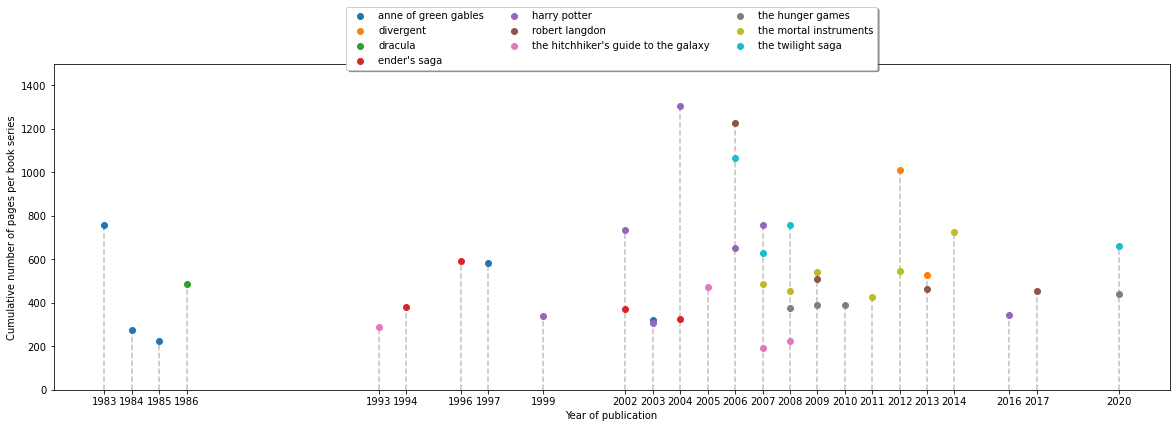

In [25]:
# Figure 1

series_pages = functions.cumpage_serie(df)

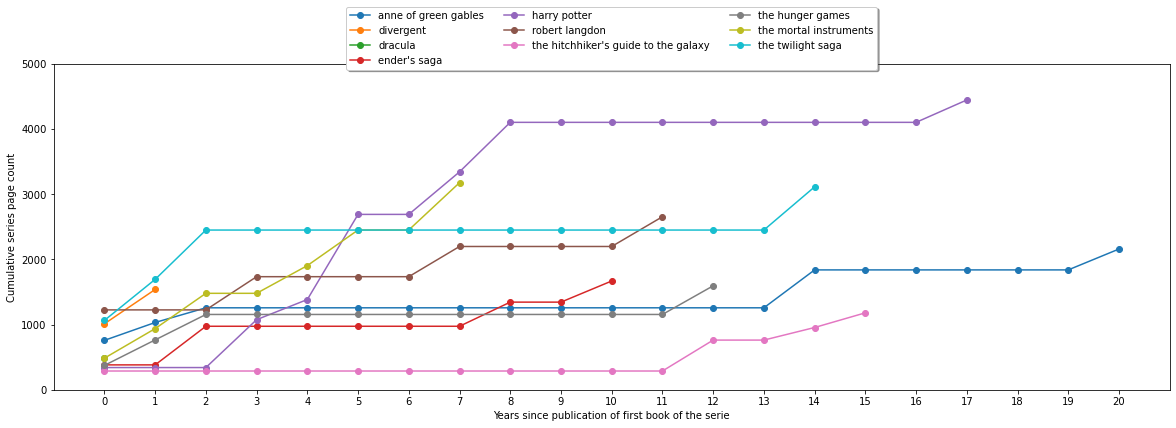

In [26]:
# Figure 2

functions.year_pages_visualization(series_pages)

# 5. Algorithmic Question

## 5.1 Recursive implementation

In [27]:
def helper(arr, pos):
    prev_elements = [i for i in range(pos) if arr[i] < arr[pos]]
    if len(prev_elements) == 0:
        return 1
    return 1 + max([helper(arr, i) for i in prev_elements])

def lis(arr):
    return max([helper(arr, i) for i in range(len(arr))])

**Observation 1:**

As we can see, the algorithm does what it should do with small strings.

In [28]:
s = 'CADFECEILGJHABNOFPSTIRYOEABILCNR'
lis(s)

11

In [29]:
s = 'ABABABAB'
lis(s)

2

**Observation 2:**

Problem raises when there are consecutive alphabetical characters. That is, in fact, the worst possible case. Let's try it!

In [30]:
import time

s = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
start = time.time()
lis(s)
end = time.time()

print('Time for execution: {:.2f}s'.format(end - start))

Time for execution: 46.36s


We can see that with just 26 characters in an alphabetical order, our algorithm takes a pretty long time. If we try to use this algorithm with something even longer (e.g., a list `[1, 2, 3, ..., 100]`; notice that the algorithm also works with lists!) it wouldn't actually end in a reasonable time.

### Computational complexity

<img src='./images/tree.png' class='center' width="1000" />

The previous figure represent the number of nodes at each step. We can easily see that at each step we have that, representing with $f(i)$ the number of nodes at step $i$:

$$f(n) = 1 + f(n - 1) + f(n - 2) + \dots + f(1) = 1 + \sum_{i = 1}^{n - 1} f(i)$$

where the addends of the above formula represent respectively the root of the tree, the number of nodes for the sub-tree which has $n - 1$ as root, the number of nodes for the sub-tree which has $n - 2$ as root, and so on so forth.

Now, we can prove that the total number of nodes is exactly $2^{n - 1}$. If we try this for small numbers, this is trivial; if we want to prove this, we can use strong induction on $n$:

At step 1, we obviously have $2^0 = 1$ nodes, since we just have the root node.

Let's assume that this is true $\forall k \le n$, we need to prove that this implies that this formula is also true for $n + 1$. Let's compute $f(n + 1)$ and see what we can do:

\begin{align}
    f(n + 1) & = 1 + \sum_{i = 1}^{n} f(i) = 1 + \sum_{i = 1}^{n} 2^{i - 1} = 1 + \sum_{i = 0}^{n - 1} 2^{i} \\
    & = 1 + \frac{2^n - 1}{2 - 1} = 2^n = 2^{(n + 1) - 1} \\
\end{align}

which is exactly what we were trying to prove.

Now, each node has complexity $O\,(n)$ in the worst case, since there is the computation of the previous elements. Having an exponential number of nodes, this means that the total complexity is also exponential.

## 5.2 Dynamic implementation

In [31]:
def dyn_lis(arr):
    if len(arr) == 1:
        return 1
    fin_max = 1
    prev_lis = [1] * len(arr)
    for i in range(1, len(arr)):
        curr_max = 1
        for j in range(i):
            if arr[i] > arr[j]:
                curr_max = max(curr_max, prev_lis[j] + 1)
            prev_lis[i] = curr_max
    return max(prev_lis)

**Observation:**

Even if this is not the best solution out there (this takes $O \, (n^2)$, best solution takes $O \, (n \log n)$), we can see that this is feasible when working with reasonable inputs.

In [32]:
s = 'CADFECEILGJHABNOFPSTIRYOEABILCNR'
print('Longest increasing for `s` has lenght {}'.format(dyn_lis(s)))

big_s = range(1000)
start = time.time()
dyn_lis(big_s)
end = time.time()

print('Time for execution for `big_s` = {:.2f}s'.format(end - start))

Longest increasing for `s` has lenght 11
Time for execution for `big_s` = 0.17s


### Computational complexity

First, outside of the loop there are two functions (`len()` and `max()`) which both takes linear time $O(n)$. Inside the nested loops, there is an `if` statement, which takes $O(1)$, and since we are doing $n^2$ iterations in total, we have $O(n^2)$ for the `for` loops. Notice that the `max` in the `if` is just between two elements, so it only takes $O(1)$.

Therefore, we can conclude that the total time complexity is $O(n^2)$.

## Proof of the formula
Define as X[i] = "the length of the longest sequence of characters in alphabetical order that terminates at the *i*-th character". We want to prove that

```X[i] = 1 + max{X[j]; j = 0, ..., i-1, such that S[j]<S[i]}```

```X[i] = 1, if there does not exist such a j```

To prove that the formula is correct, we can proceed by strong induction on the lenght of the string: we prove that the formula is correct for a string of lenght $1$, then we assume it is correct $\forall i < n$, and finally we prove that this implies that the formula is also correct for $n$.

When a string is composed by just 1 character, we obviously find ourself in the second condition, so it is trivially true.

Let's suppose it is correct for each lenght $i < n$. Now, if we append a new character to the string, there are two options: either the character is longer than the last character of the longest increasing sequence, in which case we would have + 1 on the lenght of the LIS, or it isn't.

In the first case, as we already said, we would have

```X[n] = 1 + X[n - 1]```

where ```X[n - 1]``` corresponds to the lenght of the longest increasing sequence of n - 1 characters, which is exactly the max between all the LIS between the LISs of all the characters before the last one.

In the second case, the last character isn't greater than all the others. If it is smaller than all the others, than ```X[n] = 1```, obviously, and it respect the second case. If it bigger than just a subset of of characters of the string, then the LIS would be the LIS of those characters, with just this last character added. Thus, the LIS lenght would be LIS lenght of the subset of characters + 1, which proves the statement, since it would be the max between the LIS lenghts of the characters smaller than the one we are considering, plus 1.